In [1]:
import pyomo.environ as pyo
import pandas as pd
import cirq
import numpy as np
from scipy.optimize import minimize


In [2]:
def solve_battery_lp(x, prices):
    """
    Solve LP subproblem for a fixed binary schedule x.

    Args:
        x (list or np.array): binary vector (length T)
        prices (list or np.array): electricity prices

    Returns:
        obj_value (float)
        duals (dict)
        feasible (bool)
    """

    T = len(x)
    eta = 0.8
    P_charge = 5.0
    P_discharge = 4.0
    E_max = 16.0
    cycle_limit = 32.0
    model = pyo.ConcreteModel()

    model.T = pyo.RangeSet(0, T-1)

    # Variables
    model.c = pyo.Var(model.T, domain=pyo.NonNegativeReals)
    model.d = pyo.Var(model.T, domain=pyo.NonNegativeReals)
    model.e = pyo.Var(model.T, domain=pyo.NonNegativeReals)

    # Objective: maximize revenue
    model.obj = pyo.Objective(
        expr=sum(prices[t] * (model.d[t] - model.c[t]) for t in model.T),
        sense=pyo.maximize
    )

    def soc_balance(model, t):
        if t == 0:
            return model.e[t] == eta * model.c[t] - model.d[t]
        return model.e[t] == model.e[t-1] + eta * model.c[t] - model.d[t]

    model.soc_balance = pyo.Constraint(model.T, rule=soc_balance)

    model.charge_limit = pyo.Constraint(
        model.T,
        rule=lambda model, t: model.c[t] <= P_charge * x[t]
    )

    model.discharge_limit = pyo.Constraint(
        model.T,
        rule=lambda model, t: model.d[t] <= P_discharge * (1 - x[t])
    )

    model.soc_upper = pyo.Constraint(
        model.T,
        rule=lambda model, t: model.e[t] <= E_max
    )

    model.cycle_limit = pyo.Constraint(
        expr=sum(model.d[t] for t in model.T) <= cycle_limit
    )

    model.initial_soc = pyo.Constraint(expr=model.e[0] == 0)
    model.final_soc = pyo.Constraint(expr=model.e[T-1] == 0)
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    
    solver = pyo.SolverFactory("highs")  # or cplex / glpk
    result = solver.solve(model, tee=False)

    if result.solver.termination_condition != pyo.TerminationCondition.optimal:
        return None, None, False
    obj_value = pyo.value(model.obj)

    duals = {
        "mu_c": {t: model.dual[model.charge_limit[t]] for t in model.T},
        "mu_d": {t: model.dual[model.discharge_limit[t]] for t in model.T},
        "nu_e": {t: model.dual[model.soc_upper[t]] for t in model.T},
        "rho": model.dual[model.cycle_limit]
    }

    return obj_value, duals, True





In [116]:
def build_benders_cut(duals):
    beta = {}
    for t in duals["mu_c"]:
        beta[t] = 5.0 * duals["mu_c"][t] - 4.0 * duals["mu_d"][t]

    alpha = (
        32.0 * duals["rho"]
        # + 16.0 * sum(duals["nu_e"].values())
        + 4.0 * sum(duals["mu_d"].values())
    )

    return alpha, beta


In [133]:
def build_qaoa_circuit(qubits, beta_coeffs, gammas, betas):
    circuit = cirq.Circuit()

    # Initial superposition
    # circuit.append(initial_fixed_weight_state(qubits))
    circuit.append(cirq.H.on_each(*qubits))

    for layer in range(len(gammas)):
        # Cost layer
        for q, b in zip(qubits, beta_coeffs):
            circuit.append(cirq.rz(2 * gammas[layer] * b)(q))

        # XY mixer
        for i in range(len(qubits) - 1):
            circuit.append(
                cirq.ISwapPowGate(exponent=2 * betas[layer])(
                    qubits[i], qubits[i + 1]
                )
            )

    circuit.append(cirq.measure(*qubits, key="x"))
    return circuit


def expectation(samples, beta):
    energy = 0.0
    for s in samples:
        z = 1 - 2 * np.array(s)
        energy += np.dot(beta / 2, z)
    return energy / len(samples)

def initial_fixed_weight_state(qubits, K = 8):
    for i in range(K):
        yield cirq.X(qubits[i])

def run_qaoa(beta_coeffs, p=2):
    n = len(beta_coeffs)
    qubits = [cirq.LineQubit(i) for i in range(n)]
    sim = cirq.Simulator()

    def objective(params):
        gammas = params[:p]
        betas = params[p:]
        circuit = build_qaoa_circuit(qubits, beta_coeffs, gammas, betas)
        res = sim.run(circuit, repetitions=512)
        return expectation(res.measurements["x"], beta_coeffs)

    init = np.random.uniform(0, np.pi, size=2 * p)

    opt = minimize(objective, init, method="COBYLA", options={"maxiter": 50})

    gammas = opt.x[:p]
    betas = opt.x[p:]

    final_circuit = build_qaoa_circuit(qubits, beta_coeffs, gammas, betas)
    result = sim.run(final_circuit, repetitions=10_000)

    return result

In [ ]:

# -------------------------------
# Configuration
# -------------------------------

PRICE_FILE = "input_data.csv"
T = 24
MAX_ITERS = 20
TOL = 1e-3
QAOA_LAYERS = 4

x_init = np.random.randint(0, 2, size=T)
df = pd.read_csv('input_data.csv')
prices = (df["price"].values)[0:T]


# -------------------------------
# Initialization
# -------------------------------

cuts = []  # list of (alpha, beta)
LB = -1e12
UB = 1e12

# Initial random binary schedule
x_current = np.random.randint(0, 2, size=T)

print("Starting hybrid Benders–QAOA loop\n")

# -------------------------------
# Main Benders loop
# -------------------------------

for it in range(1, MAX_ITERS + 1):

    print(f"=== Iteration {it} ===")

    # ---- 1. Solve LP subproblem ----
    obj, duals, feasible = solve_battery_lp(x_current, prices)

    if not feasible:
        raise RuntimeError("Feasibility cuts not implemented in this example")

    # Update lower bound
    LB = max(LB, obj)

    # ---- 2. Build Benders cut ----
    alpha, beta = build_benders_cut(duals)
    beta = np.array(list(beta.values()))

    cuts.append((alpha, beta))

    print(f"LP objective value: {obj:.3f}")
    print(f"Lower bound (LB):   {LB:.3f}")

    # ---- 3. Update upper bound (surrogate) ----
    # UB is the best value the master still believes possible
    # We evaluate the current cut at x_current
    UB = min(UB, alpha + beta @ x_current)

    print(f"Upper bound (UB):   {UB:.3f}")

    # ---- 4. Convergence check ----
    gap = UB - LB
    print(f"Gap (UB - LB):      {gap:.6f}")

    # if gap <= TOL:
        # print("\nConverged.")
        # break

    # ---- 5. Select cut for QAOA ----
    # Path A: use the most recent cut (simple, valid choice)
    _, beta_for_qaoa = cuts[-1]

    # ---- 6. Run QAOA to propose new x ----
    qaoa_result = run_qaoa(beta_for_qaoa, p=QAOA_LAYERS)

    # Extract most frequent bitstring
    samples = qaoa_result.measurements["x"]
    counts = {}

    for s in samples:
        bitstring = "".join(map(str, s[::-1]))
        counts[bitstring] = counts.get(bitstring, 0) + 1

    best_bitstring = max(counts, key=counts.get)
    x_current = np.array([int(b) for b in best_bitstring])

    print(f"New x from QAOA:    {x_current}\n")

Starting hybrid Benders–QAOA loop

=== Iteration 1 ===
LP objective value: 1302.110
Lower bound (LB):   1302.110
Upper bound (UB):   1302.110
Gap (UB - LB):      -0.000000


In [135]:
x_current

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0])

In [136]:

# -------------------------------
# Final result
# -------------------------------

print("=== Final Result ===")
print("Best schedule found:")
print(x_current)

final_obj, _, _ = solve_battery_lp(x_current, prices)
print(f"Optimal revenue: {final_obj:.3f}")

=== Final Result ===
Best schedule found:
[0 1 1 0 0 1 1 1 1 1 0 0]
Optimal revenue: 0.000


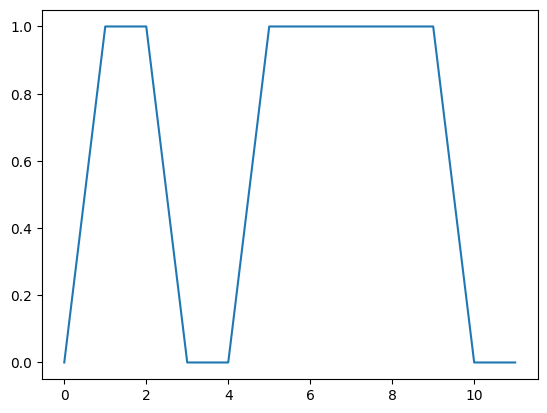

In [137]:
import matplotlib.pyplot as plt

plt.plot((x_current))